# Neural Network approach

In [1]:
!python --version

Python 3.7.13


## Libraries and methods

In [2]:
#libraries
from google.colab import drive
import pandas as pd
from sklearn.model_selection import train_test_split
#plots
import matplotlib.pyplot as plt
import seaborn as sns
#model construction and training
import torch
import torchtext
from torchtext.legacy.data import Field, TabularDataset, BucketIterator
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
import torch.optim as optim
#cross validation
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
#evaluation
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [3]:
#hyperparameters
first_n_words = 3 #or 150
clean_text = True #otherwise, it will be used "text"

#configuration options
k_folds = 5
num_epochs = 1
loss_function = nn.CrossEntropyLoss()

In [4]:
#method that return the first n words of a string
def trim_string(x):
    x = x.split(maxsplit=first_n_words)
    x = ' '.join(x[:first_n_words])
    return x

## Import the data

In [5]:
#import of the processed dataset and the columns' names
from_drive = True
dataset = dict()
path = "/content/gdrive/MyDrive/Magistrale/Stage/data"

if from_drive == True: 
  drive.mount("/content/gdrive")
  dataset["ace"] = pd.read_csv(path + "/preprocessed_ace2.csv")
  dataset["copd"] = pd.read_csv(path + "/preprocessed_copd2.csv")
  dataset["ppi"] = pd.read_csv(path + "/preprocessed_ppi2.csv")
else: 
  dataset["ace"] = pd.read_csv(path + "/content/preprocessed_ace2.csv")
  dataset["copd"] = pd.read_csv(path + "/content/preprocessed_copd2.csv")
  dataset["ppi"] = pd.read_csv(path + "/content/preprocessed_ppi2.csv")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [6]:
i = "copd"
dataset[i].columns

Index(['Unnamed: 0', 'Label', 'n_words_in_Abstract', 'text', 'text_clean',
       'n_words_in_text_clean', 'contains_topic', 'contains_other_topic'],
      dtype='object')

In [7]:
if clean_text == True: 
  text_col = "text_clean"
else: 
  text_col = "text"

dataset[i].drop(dataset[i].columns.difference(['Label', text_col]), 1, inplace=True)

#trim text_col to first_n_words
dataset[i][text_col] = dataset[i][text_col].apply(trim_string)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  


In [8]:
dataset[i].head()

,Label,text_clean
0,0,the soluble form
1,1,interactive effect of
2,0,trx ask1 jnk
3,0,increased activation of
4,0,cigarette smoke extract


In [9]:
import unicodedata
import string

all_letters = string.ascii_letters + " .,;0123456789'" #string of all the allowed characters
n_letters = len(all_letters) #number of allowed characters

#turn a Unicode string to plain ASCII
def unicodeToAscii(s):
  return ''.join(
    c for c in unicodedata.normalize('NFD', s)
    if unicodedata.category(c) != 'Mn'
    and c in all_letters
  )

dataset[i][text_col] = dataset[i][text_col].apply(lambda x: unicodeToAscii(x))

all_categories = [0, 1]
n_categories = len(all_categories)

In [10]:
dataset[i].head()

,Label,text_clean
0,0,the soluble form
1,1,interactive effect of
2,0,trx ask1 jnk
3,0,increased activation of
4,0,cigarette smoke extract


### Turning words into tensors

In [11]:
#find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
  return all_letters.find(letter)

#turn a line into a <line_length x 1 x n_letters> or an array of one-hot letter vectors
def rowToTensor(line):
  tensor = torch.zeros(len(line), 1, n_letters)
  for li, letter in enumerate(line):
    tensor[li][0][letterToIndex(letter)] = 1
  return tensor

## Creating the network

The RNN module is just 2 linear layers which operate on an input and hidden state, with a LogSoftmax layer after the output.

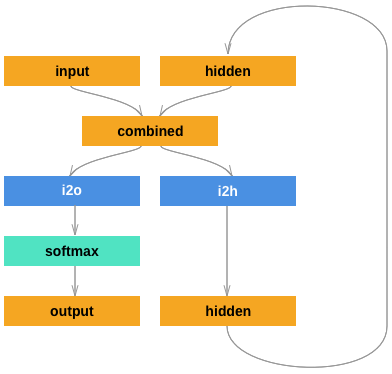


In [12]:
import torch.nn as nn

class RNN(nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
    super(RNN, self).__init__()

    self.hidden_size = hidden_size

    self.i2h = nn.Linear(input_size + hidden_size, hidden_size) #linear layer that operates on the hidden state
    self.i2o = nn.Linear(input_size + hidden_size, output_size) #linear layer that operates on the output state
    self.softmax = nn.LogSoftmax(dim=1)

  def forward(self, input, hidden):
    combined = torch.cat((input, hidden), 1)
    hidden = self.i2h(combined)
    output = self.i2o(combined)
    output = self.softmax(output)
    return output, hidden

  def initHidden(self):
    return torch.zeros(1, self.hidden_size)

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

In [13]:
#for the sake of efficiency we don’t want to be creating a new Tensor for every step
#but create a tensor for every row
#(this could be further optimized by pre-computing batches of Tensors)

input = rowToTensor('Albert')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)
print(output)
#the output is a <1 x n_categories> tensor, where every item is the likelihood of that category (higher is more likely)

tensor([[-0.7687, -0.6229]], grad_fn=<LogSoftmaxBackward0>)


## Training

### Preparing for training

In [14]:
#method to interpret the output of the network, which we know to be a likelihood of each category. 
#we can use Tensor.topk to get the index of the greatest value

def categoryFromOutput(output):
  top_n, top_i = output.topk(1)
  category_i = top_i[0].item()
  return all_categories[category_i]

In [15]:
print(categoryFromOutput(output))

1


In [16]:
#quick way to get a training example (a name and its language)

import random

def randomChoiceClass(l):
  return l[random.randint(0, len(l) - 1)]


def randomChoiceRow(l):
  return l.iloc[random.randint(0, len(l) - 1)][text_col] #given a dataset, return a random row

def randomTrainingExample():
  category = randomChoiceClass(all_categories) #choose a random category
  #x = dataset[i].loc[dataset[i]['Label'].isin([0])]
  row = randomChoiceRow(dataset[i].loc[dataset[i]['Label'].isin([category])]) #choose a random row, given a category
  category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long) #category as tensor
  row_tensor = rowToTensor(row) #line as tensor
  return category, row, category_tensor, row_tensor

for k in range(10):
  category, row, category_tensor, row_tensor = randomTrainingExample() #return a random training example
  print('category =', category, '/ row =', row)

category = 0 / row = trypsin binding activity
category = 1 / row = association of gc
category = 1 / row = tumour necrosis factor
category = 0 / row = the ability to
category = 1 / row = a nonfunctioning single
category = 0 / row = the arginine 16
category = 1 / row = the link between
category = 1 / row = heme oxygenase 1
category = 0 / row = enacbeta and gamma
category = 0 / row = evaluation of at


### Training the network

In [17]:
criterion = nn.NLLLoss() #appropriate, since the last layer of the RNN is nn.LogSoftmax
learning_rate = 0.005 #if you set this too high, it might explode. If too low, it might not learn

def train(category_tensor, row_tensor): #given input and target tensors

    #create a zeroed initial hidden state
    hidden = rnn.initHidden() 
    rnn.zero_grad()

    #read each letter in and keep hidden state for next letter
    for i in range(row_tensor.size()[0]):
        output, hidden = rnn(row_tensor[i], hidden)

    loss = criterion(output, category_tensor) #compare final output to target

    #back-propagate
    
    loss.backward() #compute gradients

    #add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item()

In [18]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000


#keep track of losses for plotting
current_loss = 0
all_losses = [] #list of all the avg losses
 
def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, row, category_tensor, row_tensor = randomTrainingExample()
    output, loss = train(category_tensor, row_tensor)
    current_loss += loss #sum of losses since last plot_every

    #print iter number, loss, name and guess
    if iter % print_every == 0: #if iter is a multiple of print_every
        guess = categoryFromOutput(output) #return predicted class and class index
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, row, guess, correct))

    #add current loss avg to list of losses
    if iter % plot_every == 0: #if iter is a multiple of plott_every
        all_losses.append(current_loss / plot_every) #append avg loss to all_losses
        current_loss = 0

5000 5% (0m 25s) 0.4289 angiogenesis is induced / 0 ✓
10000 10% (0m 43s) 1.0716 high frequency of / 0 ✗ (1)
15000 15% (1m 0s) 0.0576 alpha1 antitrypsin deficiency / 0 ✓
20000 20% (1m 18s) 0.1766 aluymicb dimorphism within / 1 ✓
25000 25% (1m 35s) 0.0606 fertility and pregnancy / 0 ✓
30000 30% (1m 52s) 0.1109 correcting the piz / 0 ✓
35000 35% (2m 9s) 0.7564 airway response to / 1 ✗ (0)
40000 40% (2m 27s) 2.1084 tissue inhibitor of / 1 ✗ (0)
45000 45% (2m 44s) 0.0735 the serpine2 gene / 1 ✓
50000 50% (3m 1s) 0.1532 attempted replication of / 1 ✓
55000 55% (3m 19s) 0.1493 gene replacement therapy / 0 ✓
60000 60% (3m 36s) 0.0376 association of variant / 0 ✓
65000 65% (3m 54s) 0.4027 anti tissue remodeling / 0 ✓
70000 70% (4m 11s) 0.0193 heterozygous alpha 1 / 0 ✓
75000 75% (4m 28s) 0.3794 genome wide linkage / 1 ✓
80000 80% (4m 46s) 0.5831 etb receptor polymorphism / 1 ✓
85000 85% (5m 3s) 0.0365 mucociliary clearance in / 0 ✓
90000 90% (5m 21s) 0.1923 endotoxin and the / 0 ✓
95000 95% (5m

## Results

### Plotting the results

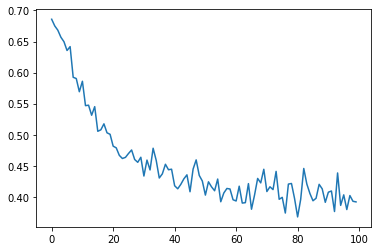

In [19]:
#plotting the historical loss from all_losses shows the network learning

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

### Evaluating the results

We will create a confusion matrix, indicating for every actual language (rows) which language the network guesses (columns).

To calculate the confusion matrix a bunch of samples are run through the network with evaluate(), which is the same as train() minus the backprop.

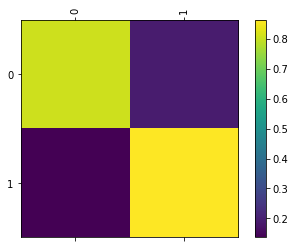

In [21]:
#keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

#just return an output given a row
def evaluate(row_tensor):
    hidden = rnn.initHidden()

    for k in range(row_tensor.size()[0]):
        output, hidden = rnn(row_tensor[k], hidden)

    return output

#go through a bunch of examples and record which are correctly guessed
for k in range(n_confusion):
    category, row, category_tensor, row_tensor = randomTrainingExample()
    output = evaluate(row_tensor)
    guess = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess] += 1

#normalize by dividing every row by its sum
for k in range(n_categories):
    confusion[k] = confusion[k] / confusion[k].sum()

# set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

#set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

#force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

In [24]:
def predict(input_line, n_predictions=2):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(rowToTensor(input_line))

        #get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('chronic obstructive pulmonary')


> chronic obstructive pulmonary
(-0.57) 0
(-0.83) 1
